In [2]:
import csv
import pdb
import re
import pdb
import sys
import pickle
import random
import zipfile

from collections import Counter
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras
import spacy
import matplotlib.pyplot as plt

random.seed(42)  # Ensure reproducible results
STEMMER = SnowballStemmer("english")
STOPWORDS = stopwords.words('english')


def read_data(remove_stopwords=True, remove_numbers=True, do_stem=True, reprocess=False):
    """ 
    Read CSV with annotated data. 
    We'll binarize the classification, i.e. subsume all hate speach related classes 
    'toxic, severe_toxic, obscene, threat, insult, identity_hate'
    into one.

    In this method we also do a lot of preprocessing steps, based on the flags which are set in the parameters.
    Feel free to try out different possible combinations of preprocessing steps (e.g. with cross-validation).
    """
    if reprocess:
        X, Y = [], []
        zip_ref = zipfile.ZipFile('train.csv.zip', 'r')
        zip_ref.extractall()
        zip_ref.close()
        for i, row in enumerate(csv.reader(open('train.csv', encoding='UTF-8'))):
            if i > 0:   # Skip the header line
                sys.stderr.write('\r'+str(i))
                sys.stderr.flush()
                text = re.findall('\w+', row[1].lower())
                if remove_stopwords:
                    text = [w for w in text if not w in STOPWORDS]
                if remove_numbers:
                    text = [w for w in text if not re.sub('\'\.,','',w).isdigit()]
                if do_stem:
                    text = [STEMMER.stem(w) for w in text]
                label = 1 if '1' in row[2:] else 0  # Any hate speach label 
                X.append(' '.join(text))
                Y.append(label)
        sys.stderr.write('\n')
        pickle.dump(X, open('X.pkl', 'wb'))
        pickle.dump(Y, open('Y.pkl', 'wb'))
    else:
        X = pickle.load(open('X.pkl', 'rb'))
        Y = pickle.load(open('Y.pkl', 'rb'))
    print(len(X), 'data points read')
    print('Label distribution:',Counter(Y))
    print('As percentages:')
    for label, count_ in Counter(Y).items():
        print(label, ':', round(100*(count_/len(X)), 2))
    return X, Y

ModuleNotFoundError: No module named 'keras'

## Read in data

In [2]:
print('Loading data', file=sys.stderr)
X, Y = read_data(reprocess=False)

Loading data


159571 data points read
Label distribution: Counter({0: 143346, 1: 16225})
As percentages:
0 : 89.83
1 : 10.17


## Vectorize with tf idf and downsample with 1500 features

In [7]:
print('Vectorizing with TFIDF', file=sys.stderr)
tfidfizer = TfidfVectorizer(max_features=1500)
X_tfidf_matrix = tfidfizer.fit_transform(X)
print('Data shape:', X_tfidf_matrix.shape)
do_downsample = True
if do_downsample:   # Only take 20% of the data
    X_tfidf_matrix, X_, Y, Y_ = train_test_split(X_tfidf_matrix, Y, test_size=0.8, random_state=42, stratify=Y)
    print('Downsampled data shape:', X_tfidf_matrix.shape)

Vectorizing with TFIDF


Data shape: (159571, 1500)
Downsampled data shape: (31914, 1500)


## Baseline with linear regression

In [8]:
print('Classification and evaluation', file=sys.stderr)
clf = LinearSVC(class_weight='balanced')    # Weight samples inverse to class imbalance
# Randomly split data into 80% training and 20% testing, preserve class distribution with stratify
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf_matrix, Y, test_size=0.2, random_state=42, stratify=Y)

clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred), file=sys.stderr)

#Apply cross-validation, create prediction for all data point
numcv = 3   # Number of folds
print('Using', numcv, 'folds', file=sys.stderr)
y_pred = cross_val_predict(clf, X_tfidf_matrix, Y, cv=numcv)
print(classification_report(Y, y_pred), file=sys.stderr)

Classification and evaluation
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      5734
           1       0.53      0.80      0.64       649

    accuracy                           0.91      6383
   macro avg       0.75      0.86      0.79      6383
weighted avg       0.93      0.91      0.92      6383

Using 3 folds
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     28669
           1       0.51      0.79      0.62      3245

    accuracy                           0.90     31914
   macro avg       0.74      0.85      0.78     31914
weighted avg       0.93      0.90      0.91     31914



## Train Model with two layers of 16 nodes

In [9]:
model = keras.Sequential()
model.add(keras.layers.Dense(16, input_shape=(X_tfidf_matrix.shape[1],)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(16, input_shape=(16,)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, input_shape=(16,)))
model.add(keras.layers.Activation('sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
opt = keras.optimizers.SGD(lr=0.1) #Default lr=0.01
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train.toarray(), np.array(Y_train), epochs=100, validation_data=(X_test.toarray(), np.array(Y_test)), callbacks=[es])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                24016     
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_4 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

## Analysis of model

200/200 [==============================] - 0s 855us/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5734
           1       0.88      0.66      0.75       649

    accuracy                           0.96      6383
   macro avg       0.92      0.83      0.86      6383
weighted avg       0.95      0.96      0.95      6383



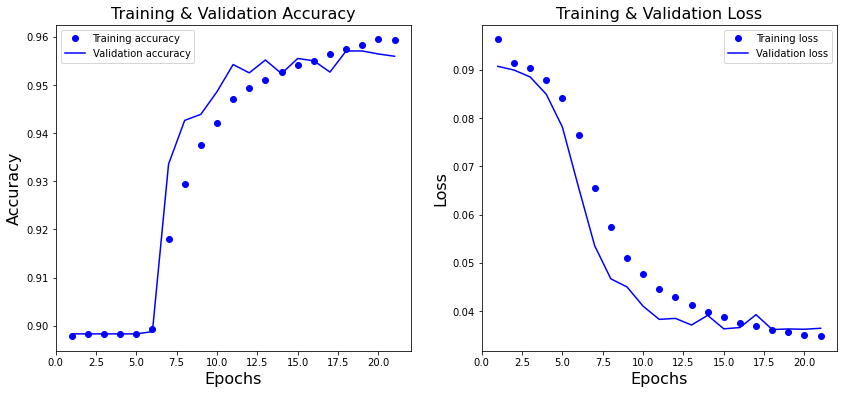

In [10]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
     
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()
    
y_pred = model.predict(X_test.toarray(), verbose=1)
y_pred_bool = np.around(y_pred)

print(classification_report(np.array(Y_test), y_pred_bool))

## Analysing Tweet

In [11]:
import tweepy 

consumer_key=''
consumer_secret=''
access_token=''
access_token_secret=''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)

id = 1389247613929676806
tweet = api.get_status(id)

#tfidf_text = tfidfizer.fit_transform([tweet.text])

y_pred = model.predict(tweet.text, verbose=1)
y_pred_bool = np.around(y_pred)
print(y_pred_bool)



IndexError: list index out of range

# CNN

In [1]:
model = keras.Sequential()
model.add(keras.layers.Conv1D(128, kernel_size=4, activation='relu', input_shape=(X_tfidf_matrix.shape[1], X_tfidf_matrix.shape[2])))
model.add(keras.layers.MaxPooling1D(pool_size=3))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(keras.layers.LSTM(32, recurrent_dropout = 0.4))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

print(model.summary())
model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, np.array(Y_train), epochs=3, batch_size=64, validation_data=(X_test, np.array(Y_test)))
print(history.history)

NameError: name 'keras' is not defined